### TFG - Cesar Hernandez Rodriguez
Quintos pasos en las redes neuronales y la bolsa, para este caso buscamos predecir valores de cierre de diferentes activos. Este script es una ema de lo que se busca en el TFG, tiene limitacion de activos de los cuales todos se predicen de una forma correcta con minimo 200 epocas.

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['IIIN', 'PRGX', 'UNFI', 'EBIO', 'MINI', 'SNCR', 'USAP', 'JMBA', 'NTLS', 'FDML']$ de los cuales $NTLS$ no cumple la condicion de que tenga datos para el test en las fechas deseadas y $FDML$ tiene pocos datos para el conjunto test

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

In [21]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

In [5]:
# Tengo dos .csv con todos los tickers que me guarda la API de Quandl y en otro con los tickers que quiero usar
# para esta demo, comparo si estan todos y los pongo en formato de descarga (WIKI/ticker)
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-funciona.csv')['Symbol']
    
    tickersQuandl = []    
    tickers = []
    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq[i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers.append(word)
    
    for tick in tickers:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

# a,b = get_tickers_sample_nasdaq()

In [54]:
# Descargo los datos de la API Quandl, para ello uso el conjunto de datos que me ofrece WIKI/ que se puede ver
# en la página de la libreria y me registro en la pagina de forma gratuita dandome una key.
# me devuelve una lista con todos los datos posibles de ese activo, yo guardo todos y por separado los de cierre
# Aunque solo me interese los de cierre quiero guardar todos los datos por si en una extension de este trabajo se queire 
# usar cualquier otro dato
# Para no tener que realizar la parte de descarga cada vez que se inicia el programa se ha habilitado la descarga
# y guardado de datos en una carpeta datos que ya debe crearse antes. Los datos se guardan serializados.

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2008-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-11-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Solo cogemos los datos que nos da la aplicacion
    # ya que hay activos que no tenemos su valor en esas fechas o tenemos muy pocos datos

    quitar = []
    for key in tickers:
        if datosClose_test[key].empty:
            if verbose == True : print("Restriccion de vacio",key) 
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
        elif len(datosClose_test[key]) < 300:
            if verbose == True :  print("Restriccion de longitud",key)
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
            
    for key in quitar:
        tickers.remove(key)
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [6]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre].plot(figsize=(12,5),grid=True)
    plt.title('{} {}\n'.format(nombre,test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [7]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



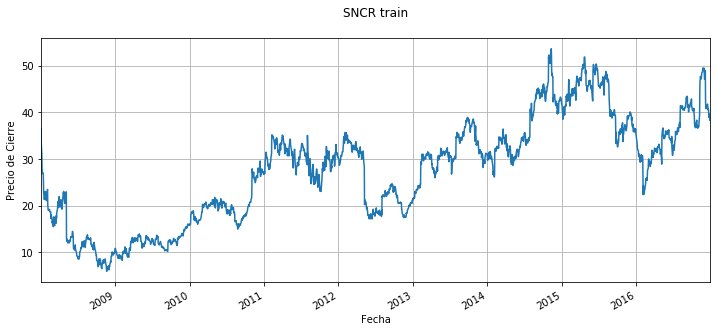

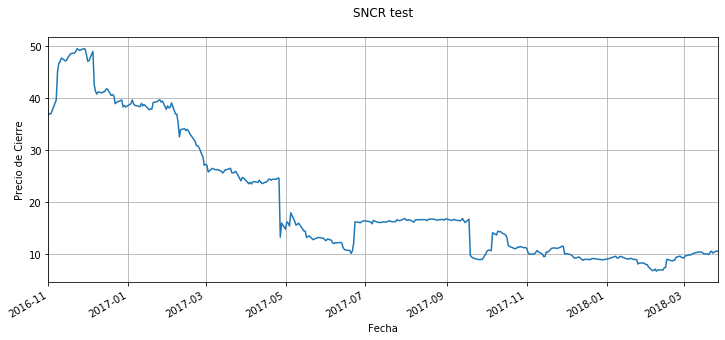

In [9]:
# Grafico un activo aleatorio que luego predecire
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers[ran],"train")
plot_datos(datosClose_test,tickers[ran],"test")

In [10]:
# Para crear los atributos que voy a meter en la red Neuronal uso esta funcion, mis atributos son
# Dos medias moviles, una de 30 dias y otra de 15 para hacer la simulacion con los datos de un mes y la mitad de mes
# por ulitmo creo un oscilador de la media movil de 30 dias donde resto los valores son separacion de 30 dias
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

    


In [12]:
# A parte de la creacion de atributos
index = ran
timeStep = 20 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers[index]],1,20)
Y = pd.DataFrame(datosClose[tickers[index]].values[21:len(datosClose[tickers[index]])])
X = X.to_numpy()

# Normalizar
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


# Creamos los atributos, normalizamos y creamos los timestep para los datos test
ticket_uso = tickers[index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers[index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers[index]].values[21:len(datosClose_test[tickers[index]])])
Xtesteo = Xtesteo.to_numpy()

# Normalizar
scaler = MinMaxScaler()
Xtesteo_scaled = scaler.fit_transform(Xtesteo)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

print("Voy a predecir el activo ",ticket_uso)



Voy a predecir el activo  SNCR


In [35]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [36]:
# Creacion de la red neural LSTM

model = Sequential()
model.add(LSTM(8, input_shape=(20,3),return_sequences=True))
model.add(LSTM(units = 4,return_sequences = False))
model.add(Dense(1)) 
model.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 20, 8)             384       
_________________________________________________________________
lstm_16 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________


In [37]:
history_LSTM = model.fit(X_train,
                  y_train,
                  epochs=500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Train on 1484 samples, validate on 742 samples
Epoch 1/500
1484/1484 [==============================] - 3s 2ms/step - loss: 867.1802 - porcentaje_margen: 0.0000e+00 - val_loss: 869.4052 - val_porcentaje_margen: 0.0000e+00
Epoch 2/500
1484/1484 [==============================] - 1s 850us/step - loss: 833.0103 - porcentaje_margen: 0.0000e+00 - val_loss: 835.3908 - val_porcentaje_margen: 0.0000e+00
Epoch 3/500
1484/1484 [==============================] - 1s 990us/step - loss: 802.6110 - porcentaje_margen: 0.0000e+00 - val_loss: 806.2088 - val_porcentaje_margen: 0.0000e+00
Epoch 4/500
1484/1484 [==============================] - 1s 914us/step - loss: 774.3625 - porcentaje_margen: 0.0000e+00 - val_loss: 779.4143 - val_porcentaje_margen: 0.0000e+00
Epoch 5/500
1484/1484 [==============================] - 1s 928us/step - loss: 750.3323 - porcentaje_margen: 0.0000e+00 - val_loss: 757.7804 - val_porcentaje_margen: 0.0000e+00
Epoch 6/500
1484/1484 [==============================] - 1s 898us/step

1484/1484 [==============================] - 1s 813us/step - loss: 355.3131 - porcentaje_margen: 0.0574 - val_loss: 366.7259 - val_porcentaje_margen: 0.0521
Epoch 49/500
1484/1484 [==============================] - 1s 801us/step - loss: 349.4367 - porcentaje_margen: 0.0581 - val_loss: 360.8091 - val_porcentaje_margen: 0.0560
Epoch 50/500
1484/1484 [==============================] - 1s 803us/step - loss: 343.6993 - porcentaje_margen: 0.0612 - val_loss: 355.0092 - val_porcentaje_margen: 0.0560
Epoch 51/500
1484/1484 [==============================] - 1s 819us/step - loss: 338.0102 - porcentaje_margen: 0.0567 - val_loss: 349.3692 - val_porcentaje_margen: 0.0482
Epoch 52/500
1484/1484 [==============================] - 1s 846us/step - loss: 332.4633 - porcentaje_margen: 0.0470 - val_loss: 343.7779 - val_porcentaje_margen: 0.0417
Epoch 53/500
1484/1484 [==============================] - 1s 806us/step - loss: 327.0143 - porcentaje_margen: 0.0419 - val_loss: 338.3309 - val_porcentaje_margen: 

1484/1484 [==============================] - 1s 787us/step - loss: 171.5644 - porcentaje_margen: 0.0665 - val_loss: 181.7788 - val_porcentaje_margen: 0.0495
Epoch 97/500
1484/1484 [==============================] - 1s 805us/step - loss: 169.5287 - porcentaje_margen: 0.0645 - val_loss: 179.7233 - val_porcentaje_margen: 0.0495
Epoch 98/500
1484/1484 [==============================] - 1s 807us/step - loss: 167.5439 - porcentaje_margen: 0.0632 - val_loss: 177.6971 - val_porcentaje_margen: 0.0521
Epoch 99/500
1484/1484 [==============================] - 1s 837us/step - loss: 165.6383 - porcentaje_margen: 0.0598 - val_loss: 175.8103 - val_porcentaje_margen: 0.0495
Epoch 100/500
1484/1484 [==============================] - 1s 793us/step - loss: 163.8029 - porcentaje_margen: 0.0532 - val_loss: 173.8721 - val_porcentaje_margen: 0.0443
Epoch 101/500
1484/1484 [==============================] - 1s 820us/step - loss: 161.9908 - porcentaje_margen: 0.0510 - val_loss: 172.0725 - val_porcentaje_margen

1484/1484 [==============================] - 1s 798us/step - loss: 59.6916 - porcentaje_margen: 0.2436 - val_loss: 61.7760 - val_porcentaje_margen: 0.2500
Epoch 145/500
1484/1484 [==============================] - 1s 818us/step - loss: 58.0461 - porcentaje_margen: 0.2620 - val_loss: 60.1805 - val_porcentaje_margen: 0.2826
Epoch 146/500
1484/1484 [==============================] - 1s 785us/step - loss: 56.5629 - porcentaje_margen: 0.2733 - val_loss: 58.7232 - val_porcentaje_margen: 0.2678
Epoch 147/500
1484/1484 [==============================] - 1s 814us/step - loss: 55.1643 - porcentaje_margen: 0.2748 - val_loss: 57.4517 - val_porcentaje_margen: 0.2287
Epoch 148/500
1484/1484 [==============================] - 1s 828us/step - loss: 53.8041 - porcentaje_margen: 0.2804 - val_loss: 55.9008 - val_porcentaje_margen: 0.2808
Epoch 149/500
1484/1484 [==============================] - 1s 794us/step - loss: 52.4854 - porcentaje_margen: 0.2759 - val_loss: 54.4111 - val_porcentaje_margen: 0.2717


1484/1484 [==============================] - 1s 839us/step - loss: 19.3033 - porcentaje_margen: 0.5177 - val_loss: 19.8614 - val_porcentaje_margen: 0.4566
Epoch 193/500
1484/1484 [==============================] - 1s 773us/step - loss: 18.8489 - porcentaje_margen: 0.5441 - val_loss: 19.3393 - val_porcentaje_margen: 0.4735
Epoch 194/500
1484/1484 [==============================] - 1s 837us/step - loss: 18.4014 - porcentaje_margen: 0.5253 - val_loss: 19.0363 - val_porcentaje_margen: 0.4818
Epoch 195/500
1484/1484 [==============================] - 1s 831us/step - loss: 18.0938 - porcentaje_margen: 0.5208 - val_loss: 18.4661 - val_porcentaje_margen: 0.4774
Epoch 196/500
1484/1484 [==============================] - 1s 793us/step - loss: 17.5854 - porcentaje_margen: 0.5414 - val_loss: 18.1525 - val_porcentaje_margen: 0.4813
Epoch 197/500
1484/1484 [==============================] - 1s 807us/step - loss: 17.2106 - porcentaje_margen: 0.5474 - val_loss: 17.5464 - val_porcentaje_margen: 0.5143


Epoch 241/500
1484/1484 [==============================] - 1s 889us/step - loss: 6.0036 - porcentaje_margen: 0.6594 - val_loss: 6.2938 - val_porcentaje_margen: 0.6267
Epoch 242/500
1484/1484 [==============================] - 1s 791us/step - loss: 5.9285 - porcentaje_margen: 0.6458 - val_loss: 6.1714 - val_porcentaje_margen: 0.6367
Epoch 243/500
1484/1484 [==============================] - 1s 816us/step - loss: 5.8116 - porcentaje_margen: 0.6472 - val_loss: 6.2798 - val_porcentaje_margen: 0.5924
Epoch 244/500
1484/1484 [==============================] - 1s 908us/step - loss: 5.6972 - porcentaje_margen: 0.6476 - val_loss: 5.9318 - val_porcentaje_margen: 0.6393
Epoch 245/500
1484/1484 [==============================] - 1s 886us/step - loss: 5.6142 - porcentaje_margen: 0.6398 - val_loss: 5.7730 - val_porcentaje_margen: 0.6562
Epoch 246/500
1484/1484 [==============================] - 1s 818us/step - loss: 5.4046 - porcentaje_margen: 0.6691 - val_loss: 5.6450 - val_porcentaje_margen: 0.647

1484/1484 [==============================] - 1s 774us/step - loss: 2.8075 - porcentaje_margen: 0.7314 - val_loss: 2.8759 - val_porcentaje_margen: 0.7044
Epoch 291/500
1484/1484 [==============================] - 1s 836us/step - loss: 2.7443 - porcentaje_margen: 0.7083 - val_loss: 2.8567 - val_porcentaje_margen: 0.7083
Epoch 292/500
1484/1484 [==============================] - 1s 803us/step - loss: 2.7279 - porcentaje_margen: 0.7194 - val_loss: 3.0282 - val_porcentaje_margen: 0.6758
Epoch 293/500
1484/1484 [==============================] - 1s 823us/step - loss: 2.7595 - porcentaje_margen: 0.7048 - val_loss: 2.7685 - val_porcentaje_margen: 0.7140
Epoch 294/500
1484/1484 [==============================] - 1s 819us/step - loss: 2.6678 - porcentaje_margen: 0.7274 - val_loss: 2.9810 - val_porcentaje_margen: 0.6719
Epoch 295/500
1484/1484 [==============================] - 1s 826us/step - loss: 2.6394 - porcentaje_margen: 0.7292 - val_loss: 2.7149 - val_porcentaje_margen: 0.7205
Epoch 296/50

1484/1484 [==============================] - 1s 810us/step - loss: 2.2159 - porcentaje_margen: 0.7465 - val_loss: 2.1610 - val_porcentaje_margen: 0.7383
Epoch 340/500
1484/1484 [==============================] - 1s 796us/step - loss: 2.1974 - porcentaje_margen: 0.7564 - val_loss: 2.0996 - val_porcentaje_margen: 0.7409
Epoch 341/500
1484/1484 [==============================] - 1s 815us/step - loss: 2.2067 - porcentaje_margen: 0.7538 - val_loss: 2.1237 - val_porcentaje_margen: 0.7248
Epoch 342/500
1484/1484 [==============================] - 1s 789us/step - loss: 2.2017 - porcentaje_margen: 0.7524 - val_loss: 2.4475 - val_porcentaje_margen: 0.6784
Epoch 343/500
1484/1484 [==============================] - 1s 807us/step - loss: 2.1989 - porcentaje_margen: 0.7498 - val_loss: 2.1677 - val_porcentaje_margen: 0.7318
Epoch 344/500
1484/1484 [==============================] - 1s 812us/step - loss: 2.1819 - porcentaje_margen: 0.7617 - val_loss: 2.0645 - val_porcentaje_margen: 0.7474
Epoch 345/50

Epoch 388/500
1484/1484 [==============================] - 1s 782us/step - loss: 2.1169 - porcentaje_margen: 0.7598 - val_loss: 1.8175 - val_porcentaje_margen: 0.7552
Epoch 389/500
1484/1484 [==============================] - 1s 786us/step - loss: 2.0215 - porcentaje_margen: 0.7662 - val_loss: 2.4071 - val_porcentaje_margen: 0.6580
Epoch 390/500
1484/1484 [==============================] - 1s 779us/step - loss: 2.0687 - porcentaje_margen: 0.7540 - val_loss: 2.1482 - val_porcentaje_margen: 0.7070
Epoch 391/500
1484/1484 [==============================] - 1s 786us/step - loss: 2.0830 - porcentaje_margen: 0.7695 - val_loss: 1.7935 - val_porcentaje_margen: 0.7539
Epoch 392/500
1484/1484 [==============================] - 1s 784us/step - loss: 1.9945 - porcentaje_margen: 0.7777 - val_loss: 1.7843 - val_porcentaje_margen: 0.7513
Epoch 393/500
1484/1484 [==============================] - 1s 795us/step - loss: 2.0166 - porcentaje_margen: 0.7770 - val_loss: 1.8401 - val_porcentaje_margen: 0.744

1484/1484 [==============================] - 1s 825us/step - loss: 1.9099 - porcentaje_margen: 0.7717 - val_loss: 1.7144 - val_porcentaje_margen: 0.7500
Epoch 438/500
1484/1484 [==============================] - 1s 814us/step - loss: 1.9962 - porcentaje_margen: 0.7496 - val_loss: 1.9266 - val_porcentaje_margen: 0.7135
Epoch 439/500
1484/1484 [==============================] - 1s 820us/step - loss: 1.9079 - porcentaje_margen: 0.7728 - val_loss: 1.6739 - val_porcentaje_margen: 0.7734
Epoch 440/500
1484/1484 [==============================] - 1s 834us/step - loss: 1.9193 - porcentaje_margen: 0.7704 - val_loss: 1.6922 - val_porcentaje_margen: 0.7643
Epoch 441/500
1484/1484 [==============================] - 1s 794us/step - loss: 1.8948 - porcentaje_margen: 0.7711 - val_loss: 1.6639 - val_porcentaje_margen: 0.7578
Epoch 442/500
1484/1484 [==============================] - 1s 816us/step - loss: 1.8592 - porcentaje_margen: 0.7835 - val_loss: 1.7061 - val_porcentaje_margen: 0.7591
Epoch 443/50

1484/1484 [==============================] - 1s 807us/step - loss: 1.7272 - porcentaje_margen: 0.7950 - val_loss: 1.7114 - val_porcentaje_margen: 0.7322
Epoch 487/500
1484/1484 [==============================] - 1s 814us/step - loss: 1.7331 - porcentaje_margen: 0.7934 - val_loss: 1.5766 - val_porcentaje_margen: 0.7721
Epoch 488/500
1484/1484 [==============================] - 1s 789us/step - loss: 1.7397 - porcentaje_margen: 0.7852 - val_loss: 1.7974 - val_porcentaje_margen: 0.7231
Epoch 489/500
1484/1484 [==============================] - 1s 795us/step - loss: 1.7413 - porcentaje_margen: 0.7930 - val_loss: 1.5046 - val_porcentaje_margen: 0.7791
Epoch 490/500
1484/1484 [==============================] - 1s 818us/step - loss: 1.7816 - porcentaje_margen: 0.7830 - val_loss: 1.5697 - val_porcentaje_margen: 0.7830
Epoch 491/500
1484/1484 [==============================] - 1s 805us/step - loss: 1.7166 - porcentaje_margen: 0.7930 - val_loss: 1.5764 - val_porcentaje_margen: 0.7791
Epoch 492/50

#### Si vemos que necesitamos mas epocas corremos este codigo
history_LSTM = model.fit(X_train,
                  y_train,
                  initial_epoch=500,
                  epochs=1000,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

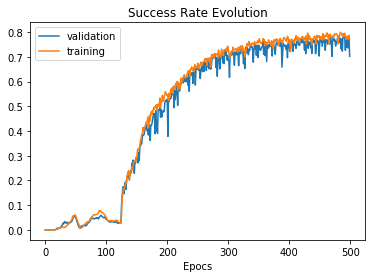

In [39]:
plt.plot(history_LSTM.epoch,history_LSTM.history['val_porcentaje_margen'],label='validation')
plt.plot(history_LSTM.epoch,history_LSTM.history['porcentaje_margen'],label="training")
plt.legend()
plt.title('Success Rate Evolution')
plt.xlabel('Epocs')
plt.show()

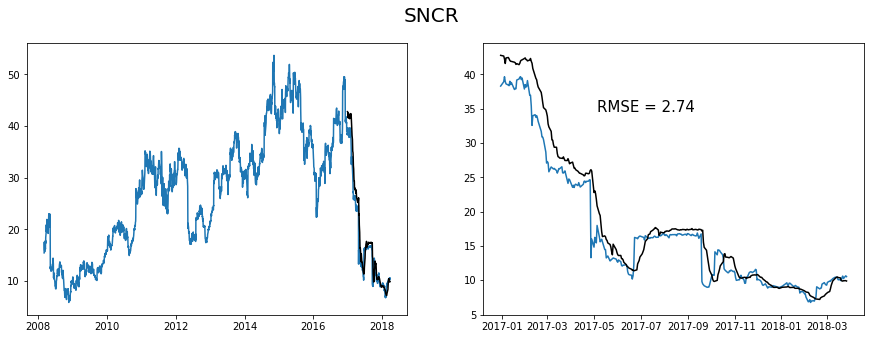

In [40]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(model.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value)
ax1.plot(index_time_t,predicted_stock_price, color = "black")

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt)
ax2.plot(index_time_t,predicted_stock_price, color = "black")
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Mido el RMSE con 200 epocas en diferentes modelos


| Ticket | 10-5-3 | 10-DROP-5,3 | 10-5 | 15-5 | 15-10 |
|--------|--------|-------------|------|------|-------|
| SNCR   | 4.28   | 13.41       | 2.58 | 2.40 | 2.23  |
| USAP   | 16.69  | 12.87       |13.68 |13.40 |18.36  |
| UNFI   | 17.50  | 18.34       |17.10 |17.55 |17.74  |


Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [41]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos

# Es un margen movil, segun lo que busquemos
margen = 0.00005
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({-1.0: 191, 1.0: 117, 0.0: 1})


In [46]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26     66704.6        0     -1  10.65  9.94717  -1
Valor Final = 66704.59
Ganancia con margen = -33295.41


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [51]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos)-1] + movimientos_ab.valor[len(movimientos)-1] * movimientos_ab.acciones[len(movimientos)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos)-1] - movimientos_ab.valor[len(movimientos)-1] * movimientos_ab.acciones_debo[len(movimientos)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      222915        0         10465     -1  10.65  9.94717  -1
Valor Final = 111462.46
Ganancia con margen = 11462.46


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [52]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos)-1] + movimientos_baja.valor[len(movimientos)-1] * movimientos_baja.acciones[len(movimientos)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos)-1] - movimientos_baja.valor[len(movimientos)-1] * movimientos_baja.acciones_debo[len(movimientos)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      328814        0         15437     -1  10.65  9.94717  -1
Valor Final = 164409.57
Ganancia con margen = 64409.57


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  